### KNN Regression Exercise:

This is using the same Divvy Bikeshare Dataset, but I did limit it further since the KNN model takes a bit longer to run. 

In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn import neighbors
from sklearn.model_selection import train_test_split, cross_val_score
pd.options.display.float_format = '{:.3f}'.format

%matplotlib inline

import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

/usr/local/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [2]:
# Importing and isolating the data:

raw_data = pd.read_csv("Divvy_BikeShare.csv")
data = pd.DataFrame()
data = pd.DataFrame(raw_data[['trip_id', 'year', 'month', 'week', 'day', 'gender',
                 'tripduration', 'temperature', 'events']])

In [3]:
data['temperature2'] = data['temperature']

In [4]:
yr_1 = data.loc[data['year'] == 2014]

#### Trying Temperature as the predicitor:

We will start with an unweighted model, then move to a weighted model.  In the cell above, the data was isolated to the year 2014.

In [4]:
knn = neighbors.KNeighborsRegressor(n_neighbors = 5)

x = pd.DataFrame(yr_1['temperature'])
y = pd.DataFrame(yr_1['tripduration'])

In [5]:
knn.fit(x, y)

T = np.arange(0, 100, 0.5)[:, np.newaxis]

In [6]:
Y_ = knn.predict(T)
    
cross_val_score(knn, x, y, cv = 10)
    

array([-0.16927515, -0.26272963, -0.1704002 , -0.13981079, -0.23598719,
       -0.24324145, -0.26018374, -0.18224519, -0.29409607, -0.15648347])

Negative scores are to be avoided at all costs, so we will continue to look at narrowing the data as well as 
tweaking the model (adjusting neighbor count, weighting the model, varying the fold size of the validation set).

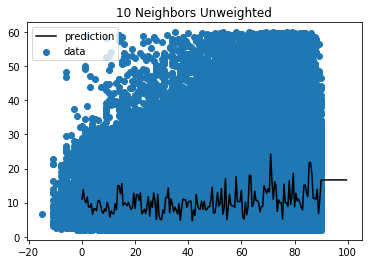

In [7]:
plt.scatter(x, y, label = 'data')
plt.plot(T, Y_, c = 'black', label = 'prediction')
plt.legend()
plt.title("{} Neighbors Unweighted".format(10))
plt.show()
    

#### Trying the weighted version

In [10]:
trial = yr_1.loc[(yr_1['temperature'] >= 50) & (yr_1['temperature'] <= 82) &
         (yr_1['tripduration'] >= 0) & (yr_1['temperature'] >= 3)]

In [11]:
# Now the weighted/distance model:

knn_w = neighbors.KNeighborsRegressor(n_neighbors = 5, weights = 'distance')

x1 = pd.DataFrame(trial['temperature'])
y1 = pd.DataFrame(trial['tripduration'])
    

In [12]:
knn_w.fit(x1, y1)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='distance')

In [13]:
T1 = np.arange(0, 100, 0.5)[:, np.newaxis]  

Y1_ = knn_w.predict(T1) 

In [14]:
cross_val_score(knn_w, x1, y1, cv = 10)
    

KeyboardInterrupt: 

In [ ]:
plt.scatter(x1, y1, label = 'data')
plt.plot(T1, Y1_, label = 'prediction')
plt.legend()
plt.title("5 Weighted Neighbors")
plt.show()

### Re-do:

This is the point where I remembered to engineer my own column for the target data.  So, here we go again:  

In [21]:
trial = pd.DataFrame(data.loc[(data['tripduration'] <= 3) & (data['tripduration'] >= 0) &
         (data['temperature'] <= 40) & (data['temperature'] >= 20)])

temp = trial.groupby('temperature').transform('count')

trial['temp_count'] = temp['trip_id']
trial['temp_percent'] = (trial['temp_count'])*100 / 54404

In [22]:
knn_x = neighbors.KNeighborsRegressor(n_neighbors = 20, weights = 'distance')

a = pd.DataFrame(trial.temperature)
b = pd.DataFrame(trial.temp_percent)

knn_x.fit(a, b)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=20, p=2,
          weights='distance')

In [23]:
Tx = np.arange(20, 45, 0.1)[:, np.newaxis]  

Yx_ = knn_x.predict(Tx) 

In [24]:
cross_val_score(knn_x, a, b, cv = 6)

array([0.99972982, 1.        , 1.        , 1.        , 1.        ,
       1.        ])

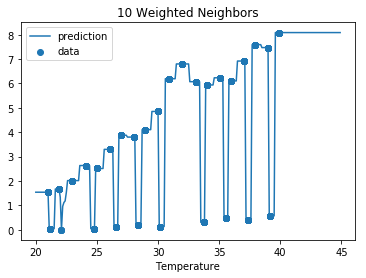

In [9]:
plt.scatter(a, b, label = 'data')
plt.plot(Tx, Yx_, label = 'prediction')
plt.legend()
plt.xlabel("Temperature")
plt.ylabel("")
plt.title("10 Weighted Neighbors")
plt.show()

While these scores show that I have successfully reversed the problem, it is, however, a reversed problem.  Somehow, this is overfitting and I am not sure if I have made an error (which is my current guess) or if I have some more tweaking to do. 

#### Running the model on the whole dataset:

Here, I am trying a similar tactic as I implemented with the trial data-frame above, but with the entire dataset.  

In [13]:
beta = yr_1.groupby('temperature').count()

In [14]:
beta['temp_count'] = beta['trip_id']

In [15]:
beta['temp_pct'] = beta['temp_count'] / 1615683


In [29]:
knn_beta = neighbors.KNeighborsRegressor(n_neighbors = 20, weights = 'distance')

In [30]:
X1 = beta[['temperature2', 'tripduration']]
Y1 = beta['temp_pct']

In [31]:
knn_beta.fit(X1, Y1)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=20, p=2,
          weights='distance')

In [32]:
cross_val_score(knn_beta, X1, Y1, cv = 6)

array([0.9168286 , 0.99804201, 0.98219394, 0.99535344, 0.93992607,
       0.92769717])

So here, I decided to look at the first year of the data (since looking at the entire dataset was taking awhile to  run).  Anyways, these scores are making a lot more sense here, but with the same dataset, the OLS model is overfitting quite a bit.  

Generally, a KNN model would offer a bit more specificity and flexibility, allowing you to manipulate the fitting process a bit more (i.e. modifying the number of neighbors (closer datapoints) and the weight you want to use when considering their distance from the datapoint in question).  For example, if you decide to look at only 2 or 3 of the points closest to the datapoint in question, it might have a tendency to overfit by letting only a few datapoints determine the prediction of the point in question.  If you have more neighbors, it will be a more generalized prediction since you are getting feedback from a larger number of datapoints with their own characteristics.  Weighting can also allow you to control the amount of consideration you give to the distance between these neighbors and the datapoint in question.  A neighbor that is farther away would have less impact on a prediction than a neighbor that is closer.

I imagine, that give the size of this data-set, the OLS model, which is usually more general and less prone to over-fitting, is over-fitting in this case because of the large number of datapoints it has.  The KNN, however, is more sensitive to the neighbors surrouinding each datapoint, and less sensitive to the neighbors which are farther away, so it is over-fitting a bit less in this case.